Data: New York city public schools
Since aforementioned dataset is massive, I've decided to narrow the scope down to specific area of studies. 

Scope: SAT scores of high school students along with various demographic and other information about them. 

## What is the SAT? 

Scholastic Aptitude Test, is a test that high schoolers take in the US before applying to college. Colleges take the test scores into account when making admissions decisions, so it's fairly important to do well on. The test is divided into 3 sections, each of which is scored out of 800 points. The total score is out of 2400 (although this has changed back and forth a few times, the scores in this dataset are out of 2400). High schools are often ranked by their average SAT scores, and high SAT scores are considered a sign of how good a school district is.

## Background Information about the data
* NY city has 5 districts 
* NY has several school districts and each of which can contains dozens of schools 
* Not all the schools in all of the datasets are high schools, so I need to do some data cleaning. 
* Each school in NY has a unique code it's `DBN` or District Borough Number
* By aggregating data by district, I can use the district mapping data to plot district-by-district differences.



In [1]:
import pandas 
import numpy as np 
# ignore this
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Adding all of the file names into an array
files = ["ap_2010.csv", "class_size.csv", "demographics.csv", "graduation.csv", "hs_directory.csv", "math_test_results.csv", "sat_results.csv"]

# Creating a dictionary by reading all of the data files under data folder
data = {}

for f in files:
    d = pandas.read_csv("datasets/nyc_education/{0}".format(f))
    data[f.replace(".csv","")] = d 

Printing first five lines of read DataFrames 

In [3]:
for k,v in data.items():
    print("\n" + k + "\n")
    print(v.head())


ap_2010

      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  

class_size

   CSD BOROUGH SCHOOL CODE                SCHOOL NAME GRADE  PROGRAM TYPE  \
0    1       M        M015  P.S. 015 Roberto Clemente     0K       GEN ED   
1    1       M        M015  P.S. 015 Roberto Clemente     0K

Observed patterns as follows, 
* Most of the datasets contain a `DBN` column 
* Some fields are interesting for mapping. Such as `Location 1`
* Some of the datasets appear to contain multiple rows for each school (repeated DBN values), which means I'll have to do some preprocessing.

## Unifying the data 

Firstly, It is must to identify a common column to unify all datasets. It appears `DBN` is the common column. `DBN` is a unique code for each school.

The problem now is that two of the datasets, `class_size`, and `hs_directory`, don't have a `DBN` field. In the `hs_directory` data, it's just named as `dbn`, it just a mattter of renaming the column. But the `class_size` data needs a different approach. 

The `DBN` column looks like this: 

In [4]:
data["ap_2010"]["DBN"].head()

0    01M448
1    01M450
2    01M515
3    01M539
4    02M296
Name: DBN, dtype: object

In `class_size` data 

In [5]:
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN


looks of it `DBN` is the combination of `CSD`, `BOROUGH` and `SCHOOL CODE`. Now that I know how to construct the DBN, I can add it into the class_size and hs_directory datasets: 

In [6]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]
data["class_size"]["DBN"] = data["class_size"].apply(lambda x: "{0:02d}{1}".format(x["CSD"], x["SCHOOL CODE"]), axis=1)

In [7]:
data["class_size"]["DBN"].head()

0    01M015
1    01M015
2    01M015
3    01M015
4    01M015
Name: DBN, dtype: object

In [8]:
data["hs_directory"]["DBN"].head()

0    17K548
1    09X543
2    09X327
3    02M280
4    28Q680
Name: DBN, dtype: object

## Adding in the surveys

Since survey data consists with 2 files, one for all schools, and one for school district 75. 

In [9]:
s1 = pandas.read_csv("datasets/nyc_education/survey_all.txt", delimiter="\t", encoding='windows-1252')
s2 = pandas.read_csv("datasets/nyc_education/survey_d75.txt", delimiter="\t", encoding='windows-1252')
s1["d75"],s2["d75"] = False, True 
survey = pandas.concat([s1,s2],axis=0)

In [10]:
survey.head()

,N_p,N_s,N_t,aca_p_11,aca_s_11,aca_t_11,aca_tot_11,bn,com_p_11,com_s_11,...,t_q8c_1,t_q8c_2,t_q8c_3,t_q8c_4,t_q9,t_q9_1,t_q9_2,t_q9_3,t_q9_4,t_q9_5
0,90.0,NaN,22.0,7.8,NaN,7.9,7.9,M015,7.6,NaN,...,29.0,67.0,5.0,0.0,NaN,5.0,14.0,52.0,24.0,5.0
1,161.0,NaN,34.0,7.8,NaN,9.1,8.4,M019,7.6,NaN,...,74.0,21.0,6.0,0.0,NaN,3.0,6.0,3.0,78.0,9.0
2,367.0,NaN,42.0,8.6,NaN,7.5,8.0,M020,8.3,NaN,...,33.0,35.0,20.0,13.0,NaN,3.0,5.0,16.0,70.0,5.0
3,151.0,145.0,29.0,8.5,7.4,7.8,7.9,M034,8.2,5.9,...,21.0,45.0,28.0,7.0,NaN,0.0,18.0,32.0,39.0,11.0
4,90.0,NaN,23.0,7.9,NaN,8.1,8.0,M063,7.9,NaN,...,59.0,36.0,5.0,0.0,NaN,10.0,5.0,10.0,60.0,15.0


remove any extraneous columns in `survey`

In [11]:
survey["DBN"] = survey["dbn"]
survey_fields = ["DBN", "rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_p_11", "com_p_11", "eng_p_11", "aca_p_11", "saf_t_11", "com_t_11", "eng_t_10", "aca_t_11", "saf_s_11", "com_s_11", "eng_s_11", "aca_s_11", "saf_tot_11", "com_tot_11", "eng_tot_11", "aca_tot_11",]
survey = survey.loc[:,survey_fields]
data["survey"] = survey
survey.shape

(1702, 23)

## Condensing datasets

`class_size` has several raws for each high school whereas, `sat_results` has only one 

In [12]:
data["class_size"].head()

,CSD,BOROUGH,SCHOOL CODE,SCHOOL NAME,GRADE,PROGRAM TYPE,CORE SUBJECT (MS CORE and 9-12 ONLY),CORE COURSE (MS CORE and 9-12 ONLY),SERVICE CATEGORY(K-9* ONLY),NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,DATA SOURCE,SCHOOLWIDE PUPIL-TEACHER RATIO,DBN
0,1,M,M015,P.S. 015 Roberto Clemente,0K,GEN ED,-,-,-,19.0,1.0,19.0,19.0,19.0,ATS,NaN,01M015
1,1,M,M015,P.S. 015 Roberto Clemente,0K,CTT,-,-,-,21.0,1.0,21.0,21.0,21.0,ATS,NaN,01M015
2,1,M,M015,P.S. 015 Roberto Clemente,01,GEN ED,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
3,1,M,M015,P.S. 015 Roberto Clemente,01,CTT,-,-,-,17.0,1.0,17.0,17.0,17.0,ATS,NaN,01M015
4,1,M,M015,P.S. 015 Roberto Clemente,02,GEN ED,-,-,-,15.0,1.0,15.0,15.0,15.0,ATS,NaN,01M015


In [13]:
data["sat_results"].head()

,DBN,SCHOOL NAME,Num of SAT Test Takers,SAT Critical Reading Avg. Score,SAT Math Avg. Score,SAT Writing Avg. Score
0,01M292,HENRY STREET SCHOOL FOR INTERNATIONAL STUDIES,29,355,404,363
1,01M448,UNIVERSITY NEIGHBORHOOD HIGH SCHOOL,91,383,423,366
2,01M450,EAST SIDE COMMUNITY SCHOOL,70,377,402,370
3,01M458,FORSYTH SATELLITE ACADEMY,7,414,401,359
4,01M509,MARTA VALLE HIGH SCHOOL,44,390,433,384


Problem: datasets like `class_size` to the point where there's only a single row per high school. If not, there won't be a way to compare SAT scores to class size. 
Solution: perform some aggregations, some observations as follows,
* Looks like `GRADE` and `PROGRAM TYPE` have mulitiple values for each school. By restricting each field to a single value, we can filter most of the duplicate rows.
* Only select values from `class_size` where the `GRADE field` is `09-12`
* Only select values from `class_size` where the `PROGRAM TYPE` field is `GEN ED`
* Group the `class_size` dataset by `DBN`, and take the average of each column. Essentially, we'll find the average `class_size` values for each school.
* Reset the index, so DBN is added back in as a column.

In [14]:
class_size = data["class_size"]
print("Before: " + str(len(class_size)))
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]
class_size = class_size.groupby("DBN").agg(np.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size
print("After: " + str(len(class_size)))
data['class_size'].head()

Before: 27611
After: 583


,DBN,CSD,NUMBER OF STUDENTS / SEATS FILLED,NUMBER OF SECTIONS,AVERAGE CLASS SIZE,SIZE OF SMALLEST CLASS,SIZE OF LARGEST CLASS,SCHOOLWIDE PUPIL-TEACHER RATIO
0,01M292,1,88.0000,4.000000,22.564286,18.50,26.571429,NaN
1,01M332,1,46.0000,2.000000,22.000000,21.00,23.500000,NaN
2,01M378,1,33.0000,1.000000,33.000000,33.00,33.000000,NaN
3,01M448,1,105.6875,4.750000,22.231250,18.25,27.062500,NaN
4,01M450,1,57.6000,2.733333,21.200000,19.40,22.866667,NaN


## Condensing other datasets

The `demographics` dataset. The data was collected for multiple years for the same schools, so there are duplicate rows for each school. I only pick rows where the `schoolyear` field is the most recent available.

Also, we need to condense the math_test_results dataset. This dataset is segmented by Grade and by Year. We can select only a single grade from a single year.

Finally, `graduation` needs to be condensed

In [15]:
demographics = data["demographics"]
demographics = demographics[demographics["schoolyear"] == 20112012]
data["demographics"] = demographics

In [16]:
data["math_test_results"] = data["math_test_results"][data["math_test_results"]["Year"] == 2011]
data["math_test_results"] = data["math_test_results"][data["math_test_results"]["Grade"] == '8']

In [17]:
data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

Motivation: Data cleaning and exploration is critical before working on the core of the project. Having a good, consistent dataset will help me to do my analysis more quickly.

## Computing variables

Computing variables can help speed up our analysis by enabling us to make comparisons more quickly, and enable us to make comparisons that we otherwise wouldn't be able to do

Compute a total SAT score from the individual columns `SAT Math Avg. Score, SAT Critical Reading Avg. Score,` and `SAT Writing Avg. Score`. 

* Convert each of the SAT score columns from a string to a number.
* Add together all of the columns to get the `sat_score column`, which is the total SAT score.

In [18]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = data["sat_results"][c].convert_objects(convert_numeric=True)
data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

We'll need to parse out the coordinate locations of each school. So we can make maps. This will enable us to plot the location of each school. 

* Parse latitude and longitude columns from the `Location 1` column.
* Convert `lat` and `lon` to be numeric.

In [19]:
data["hs_directory"]['lat'] = data["hs_directory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[0])
data["hs_directory"]['lon'] = data["hs_directory"]['Location 1'].apply(lambda x: x.split("\n")[-1].replace("(", "").replace(")", "").split(", ")[1])

for c in ['lat', 'lon']:
    data["hs_directory"][c] = data["hs_directory"][c].convert_objects(convert_numeric=True)

In [20]:
for k,v in data.items():
    print(k)
    print(v.head())

ap_2010
      DBN                             SchoolName AP Test Takers   \
0  01M448           UNIVERSITY NEIGHBORHOOD H.S.              39   
1  01M450                 EAST SIDE COMMUNITY HS              19   
2  01M515                    LOWER EASTSIDE PREP              24   
3  01M539         NEW EXPLORATIONS SCI,TECH,MATH             255   
4  02M296  High School of Hospitality Management               s   

  Total Exams Taken Number of Exams with scores 3 4 or 5  
0                49                                   10  
1                21                                    s  
2                26                                   24  
3               377                                  191  
4                 s                                    s  
class_size
      DBN  CSD  NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  \
0  01M292    1                            88.0000            4.000000   
1  01M332    1                            46.0000            2.000000   

## Combining the datasets

After the preliminaries, we can combine the datasets together using the `DBN` column. At the end, we'll have a dataset with hundreds of columns, from each of the original datasets. When we join them, it's important to note that some of the datasets are missing high schools that exist in the `sat_results` dataset. 

To resolve this, we'll need to merge the datasets that have missing rows using the `outer` join strategy, so we don't lose data. 

strategy as follows,
* Loop through each of the items in the `data` dictionary.
* Print the number of non-unique `DBN`s in the item.
* Decide on a join strategy whether it's `inner` or `outer`.
* Join the item to the DataFrame `full` using the column `DBN`.

In [21]:
flat_data_names = [k for k,v in data.items()]
print(flat_data_names)
flat_data = [data[k] for k in flat_data_names]
full = flat_data[0]
for i,f in enumerate(flat_data[1:]):
    name = flat_data_names[i+1]
    print(name)
    print(len(f["DBN"]) - len(f["DBN"].unique()))
    join_type = "inner"
    if name in ["sat_results", "ap_2010", "graduation"]:
        join_type = "outer"
    if name not in ["math_test_results"]:
        full = full.merge(f, on="DBN", how=join_type)
full.shape

['ap_2010', 'class_size', 'demographics', 'graduation', 'hs_directory', 'math_test_results', 'sat_results', 'survey']
class_size
0
demographics
0
graduation
0
hs_directory
0
math_test_results
0
sat_results
0
survey
0


(471, 165)

## Adding in values


In [22]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    full[col] = full[col].convert_objects(convert_numeric=True)

full[cols] = full[cols].fillna(value=0)
full["school_dist"] = full["DBN"].apply(lambda x: x[:2])
full = full.fillna(full.mean())

## Computing correlations

In [23]:
full.corr()['sat_score']

AP Test Takers                          0.562897
Total Exams Taken                       0.551421
Number of Exams with scores 3 4 or 5    0.549217
CSD                                     0.043624
NUMBER OF STUDENTS / SEATS FILLED       0.321233
NUMBER OF SECTIONS                      0.296743
AVERAGE CLASS SIZE                      0.368949
SIZE OF SMALLEST CLASS                  0.275326
SIZE OF LARGEST CLASS                   0.291330
SCHOOLWIDE PUPIL-TEACHER RATIO               NaN
schoolyear                                   NaN
frl_percent                            -0.624215
total_enrollment                        0.291858
ell_num                                -0.111508
ell_percent                            -0.320149
sped_num                               -0.008183
sped_percent                           -0.452274
asian_num                               0.403802
asian_per                               0.541514
black_num                              -0.013158
black_per           

This gives us quite a few insights that we'll need to explore:

* Total enrollment correlates strongly with sat_score, which is surprising, because you'd think smaller schools, which focused more on the student, would have higher scores.
* The percentage of females at a school (female_per) correlates positively with SAT score, whereas the percentage of males (male_per) correlates negatively.
* None of the survey responses correlate highly with SAT scores.
* There is a significant racial inequality in SAT scores (white_per, asian_per, black_per, hispanic_per).
* ell_percent correlates strongly negatively with SAT scores.

Each of these items is a potential angle to explore and tell a story about using the data.



## Setting the context

In [24]:
import folium
from folium import plugins
print(folium.__version__)

schools_heatmap = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
schools_heatmap.add_children(plugins.HeatMap([[row["lat"], row["lon"]] for name, row in full.iterrows()]))
schools_heatmap.save("heatmap.html")
schools_heatmap

0.5.0


## District level mapping

In [25]:
district_data = full.groupby("school_dist").agg(np.mean)
district_data.reset_index(inplace=True)
district_data["school_dist"] = district_data["school_dist"].apply(lambda x: str(int(x)))
print(district_data.head())

  school_dist  AP Test Takers   Total Exams Taken  \
0           1        34.777778          49.666667   
1           2        53.507692          85.153846   
2           3        57.117647          91.470588   
3           4        48.375000          62.375000   
4           5        34.200000          41.600000   

   Number of Exams with scores 3 4 or 5        CSD  \
0                             22.333333   9.748538   
1                             59.646154   8.527665   
2                             55.058824  10.851393   
3                             36.250000   6.530702   
4                             23.000000   9.561404   

   NUMBER OF STUDENTS / SEATS FILLED  NUMBER OF SECTIONS  AVERAGE CLASS SIZE  \
0                         181.632010            6.818214           24.843337   
1                         206.325295            7.502114           25.863919   
2                         231.712872            8.250289           26.173552   
3                         161.654632

In [26]:
def show_district_map(col):
    geo_path = 'datasets/nyc_education/districts.geojson'
    districts = folium.Map(location=[full['lat'].mean(), full['lon'].mean()], zoom_start=10)
    districts.choropleth(
        geo_data=geo_path,
        data=district_data,
        columns=['school_dist', col],
        key_on='feature.properties.school_dist',
        fill_color='YlGn',
        fill_opacity=0.7,
        line_opacity=0.2,
    )
    districts.save("districts.html")
    return districts

show_district_map("sat_score")

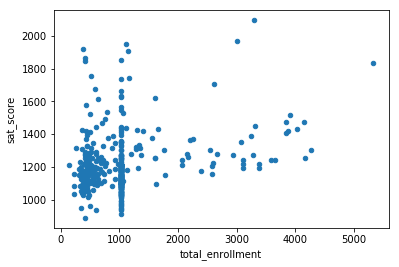

In [27]:
%matplotlib inline

full.plot.scatter(x='total_enrollment', y='sat_score')

In [28]:
full[(full["total_enrollment"] < 1000) & (full["sat_score"] < 1000)]["School Name"]

78                                       NaN
88     KINGSBRIDGE INTERNATIONAL HIGH SCHOOL
90     INTERNATIONAL SCHOOL FOR LIBERAL ARTS
155                MULTICULTURAL HIGH SCHOOL
Name: School Name, dtype: object

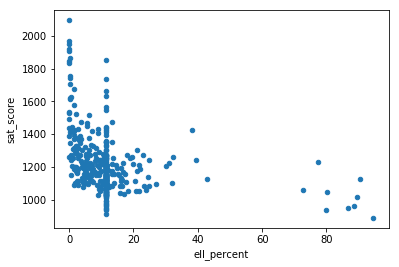

In [29]:
full.plot.scatter(x='ell_percent', y='sat_score')

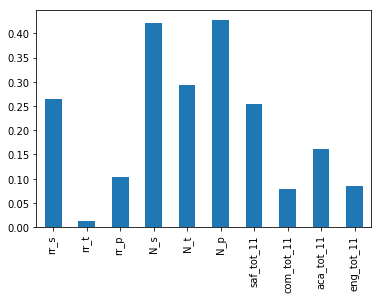

In [30]:
full.corr()["sat_score"][["rr_s", "rr_t", "rr_p", "N_s", "N_t", "N_p", "saf_tot_11", "com_tot_11", "aca_tot_11", "eng_tot_11"]].plot.bar()